In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import random

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Definir carpetas y parámetros
TRAIN_DIR = './data/images/train/'
TEST_DIR = './data/images/test/'
IMG_SIZE = 48
BATCH_SIZE = 32
EPOCHS = 30

# Función de preprocesamiento
def preprocess_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Leer imagen en escala de grises
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Redimensionar a 48x48
    img = img / 255.0  # Normalizar
    return img

# Cargar datos
def load_data(directory):
    X = []
    y = []
    filenames = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                file_path = os.path.join(root, file)
                try:
                    img = preprocess_image(file_path)
                    X.append(img)
                    # Extraer la etiqueta de la carpeta padre
                    label = os.path.basename(root)
                    y.append(0 if label == 'sad' else 1)  # 0: sad, 1: happy
                    filenames.append(file)
                except Exception as e:
                    print(f'Error al cargar {file_path}: {e}')
                    
    return np.array(X), np.array(y), filenames

# Cargar datos de entrenamiento y prueba
X_train, y_train, train_filenames = load_data(TRAIN_DIR)
X_test, _, test_filenames = load_data(TEST_DIR)

# Asegurarse de que las imágenes sean de 48x48x1 (1 canal para escala de grises)
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [4]:
# Crear el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [5]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
# Aumentación de datos
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [7]:
# Entrenar el modelo
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

Epoch 1/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8247 - loss: 0.4685 - val_accuracy: 0.8343 - val_loss: 0.4394
Epoch 2/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8278 - loss: 0.4585 - val_accuracy: 0.8343 - val_loss: 0.4325
Epoch 3/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8299 - loss: 0.4487 - val_accuracy: 0.8343 - val_loss: 0.4262
Epoch 4/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8274 - loss: 0.4426 - val_accuracy: 0.8343 - val_loss: 0.4203
Epoch 5/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8285 - loss: 0.4361 - val_accuracy: 0.8343 - val_loss: 0.4165
Epoch 6/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8286 - loss: 0.4323 - val_accuracy: 0.8343 - val_loss: 0.4083
Epoch 7/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8274 - loss: 0.4282 - val_accuracy: 0.8345 - val_loss: 0.4096
Epoch 8/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8289 - loss: 0.4208 - 

In [8]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validación - Pérdida: {val_loss}, Precisión: {val_accuracy}')

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8388 - loss: 0.3831
Validación - Pérdida: 0.375870943069458, Precisión: 0.8409366607666016


In [9]:
# Predicciones en el conjunto de prueba
y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype(int).flatten()

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [10]:
# # Guardar las predicciones en el formato requerido
# submission1 = pd.DataFrame({'Image': test_filenames, 'Prediction': y_test_pred})
# submission1.to_csv('submission.csv', index=False)

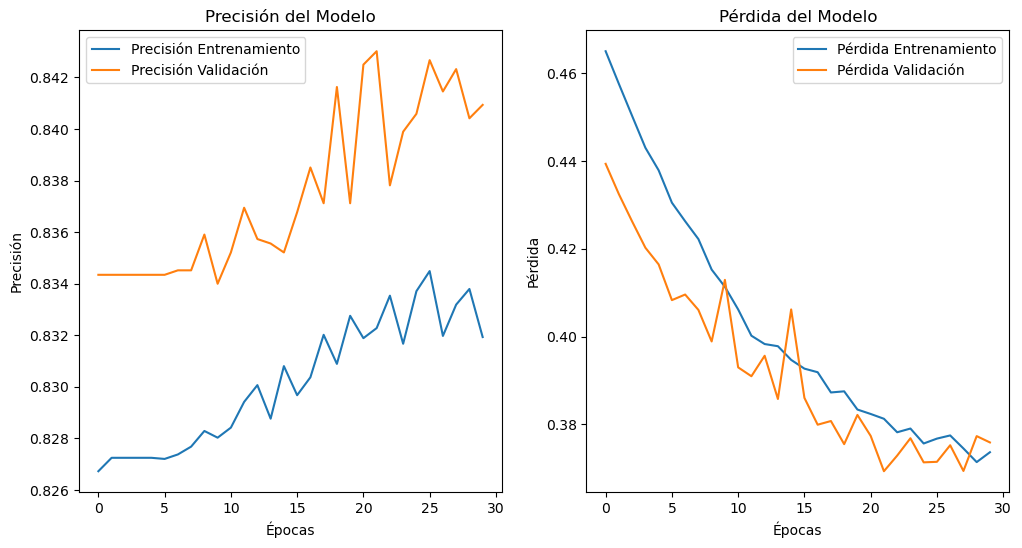

In [11]:

# Opcional: Visualización de resultados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida del Modelo')
plt.show()